In [70]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import os
import cv2
from concurrent.futures import ThreadPoolExecutor
sys.path.append(r"D:\My Laptop\Me\Programming\Machine Learning\Internships\Egyptian Space Agency\2012")

# Now you can import your custom library
from read_Data import read_fits

In [2]:
os.listdir('radio bursts data')

['noise and empty', 'rbtype2', 'rbtype3']

In [3]:
print(len(os.listdir(os.path.join("radio bursts data",'noise and empty')))/2)
print(len(os.listdir(os.path.join("radio bursts data",'rbtype2')))/2)
print(len(os.listdir(os.path.join("radio bursts data",'rbtype3')))/2)

494.0
525.0
1157.5


# Read the images data

In [4]:
# def read_image(full_img_path):
#     try:
#         img = cv2.imread(full_img_path)
#         return img
#     except Exception as e:
#         print(f"Warning: Error reading image '{full_img_path}': {e}")
#         return None

In [5]:

# def read_data(path, verbose=False,shape=(128,128)):
#     images = []
#     labels = []
#     names =[]
#     for img_type in tqdm(os.listdir(path)):
#         type_path = os.path.join(path, img_type)
#         img_paths = [os.path.join(type_path, img) for img in os.listdir(type_path) if img.endswith('png')]
        
#         # Use ThreadPoolExecutor for parallel image reading
#         with ThreadPoolExecutor() as executor:
#             results = list(executor.map(read_image, img_paths))
        
#         # Filter out None results and extend images and labels lists
#         for img, img_path in zip(results, img_paths):
#             if img is not None:
#                 img = cv2.resize(img,shape)
#                 images.append(img)
#                 labels.append(img_type)
#                 names.append(img_path)
#                 if verbose:
#                     print(f"Read file: {img_path}")

#         print(f'Finished reading {len(img_paths)} images of type "{img_type}".')
#     return np.array(images),np.array(names),np.array(labels)

# # Adjust the verbosity as needed


In [6]:
# images,pathes, labels = read_data('radio bursts data', verbose=False)

In [7]:
# images.shape

In [8]:
# len(pathes)

In [9]:
# labels.shape

In [10]:
# pathes_reshaped = pathes.reshape(-1, 1)
# labels_reshaped = labels.reshape(-1, 1)

# # Concatenate along axis 1
# combined = np.concatenate([pathes_reshaped, labels_reshaped], axis=1)
# print(combined.shape)

# Read the fits data

In [13]:
def read_fits_data(path, verbose=False,shape=(128,128)):
    images = []
    labels = []
    freqs = []
    times = []
    names=[]

    for img_type in tqdm(os.listdir(path)):
        type_path = os.path.join(path, img_type)
        img_paths = [os.path.join(type_path, img) for img in os.listdir(type_path) if img.endswith('fit.gz')]

        # Use ThreadPoolExecutor for parallel file reading
        with ThreadPoolExecutor() as executor:
            results = list(executor.map(read_fits, img_paths))

        # Filter out None results and extend the lists
        for (img, freq, time), img_path in zip(results, img_paths):
            if img is not None:
                img=cv2.resize(img,shape)
                names.append(img_path)
                images.append(np.array(img))
                freqs.append(freq)
                times.append(time)
                labels.append(img_type)
                if verbose:
                    print(f"Read file: {img_path}")

        print(f'Finished reading {len(img_paths)} files of type "{img_type}".')

    return np.array(images), np.array(labels), freqs, times,np.array(names)

In [14]:
images_fits, labels_fits, freqs_fits, times_fits,pathes_fits = read_fits_data('radio bursts data', verbose=False)

 33%|███▎      | 1/3 [00:06<00:12,  6.23s/it]

Finished reading 494 files of type "noise and empty".


 67%|██████▋   | 2/3 [00:12<00:06,  6.48s/it]

Finished reading 515 files of type "rbtype2".


100%|██████████| 3/3 [00:26<00:00,  8.75s/it]

Finished reading 1090 files of type "rbtype3".


In [15]:
images_fits.shape

(2099, 128, 128)

In [16]:
from collections import Counter
Counter(labels_fits)

Counter({'rbtype3': 1090, 'rbtype2': 515, 'noise and empty': 494})

# Prerpocessing the data

In [17]:
def preprocess_spectrogram(data):
    """
    Calculate the median over time for each frequency channel
    and subtract median values from each time column to remove background noise.
    """
    median_values = np.median(data, axis=0)
    processed_data = data - median_values
    return processed_data


In [18]:
preprocessed_spectrogram_data = [preprocess_spectrogram(img) for img in images_fits]
preprocessed_spectrogram_data = np.array(preprocessed_spectrogram_data)

In [19]:
print(f"Shape of preprocessed spectrogram data: {preprocessed_spectrogram_data.shape}")

Shape of preprocessed spectrogram data: (2099, 128, 128)


Text(0, 0.5, 'Frequency')

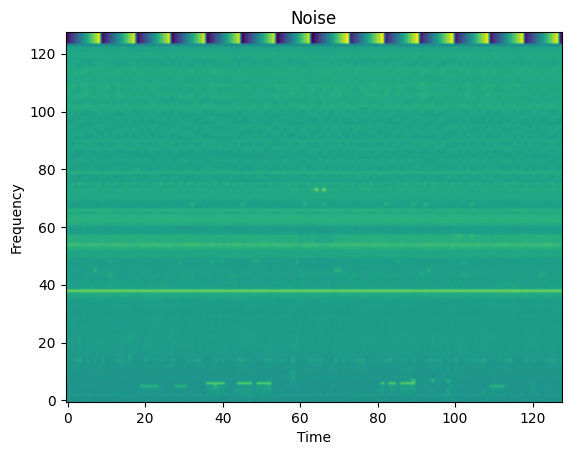

In [20]:
plt.imshow(images_fits[1], aspect='auto', origin='lower')
plt.title('Noise')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

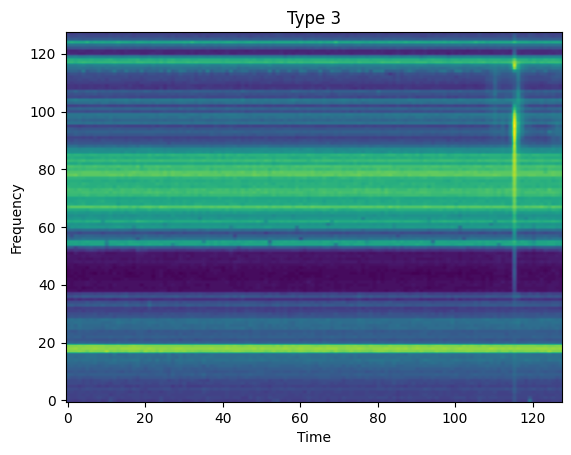

In [21]:
plt.imshow(images_fits[-1], aspect='auto', origin='lower')
plt.title('Type 3')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

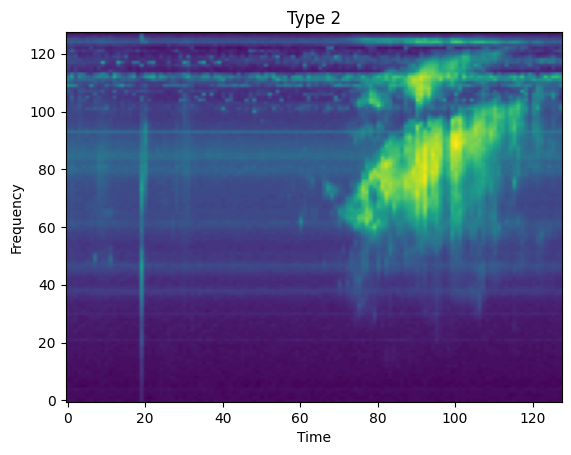

In [22]:
plt.imshow(images_fits[600], aspect='auto', origin='lower')
plt.title('Type 2')
plt.xlabel('Time')
plt.ylabel('Frequency')

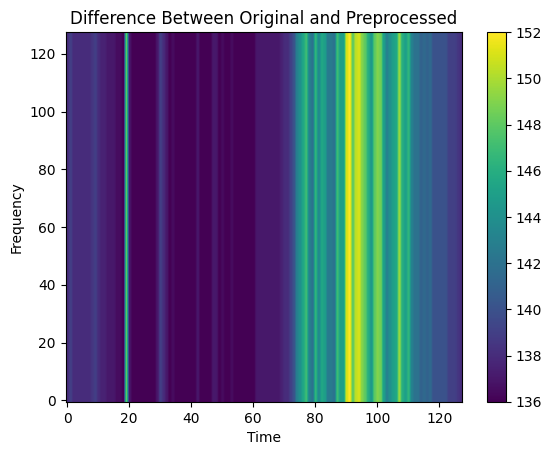

In [23]:
difference = images_fits - preprocessed_spectrogram_data
plt.imshow(difference[600], aspect='auto', origin='lower', cmap='viridis')
plt.title('Difference Between Original and Preprocessed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()


In [24]:
difference.shape

(2099, 128, 128)

In [25]:
preprocessed_spectrogram_data.shape

(2099, 128, 128)

# Deep and Machine Learning

In [26]:

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout , Add,Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [27]:
preprocessed_spectrogram_data = np.expand_dims(preprocessed_spectrogram_data, axis=-1)  # Shape will be (num_samples, 128, 128, 1)

In [28]:
difference = np.expand_dims(difference, axis=-1)  # Shape will be (num_samples, 128, 128, 1)
difference.shape

(2099, 128, 128, 1)

In [29]:
images_fits = np.expand_dims(images_fits, axis=-1)
images_fits.shape

(2099, 128, 128, 1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_spectrogram_data, labels_fits, test_size=0.2, random_state=42,shuffle=True
)

In [31]:
X_train.shape

(1679, 128, 128, 1)

In [32]:
X_test.shape

(420, 128, 128, 1)

In [33]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

In [34]:
y_test_encoded = label_encoder.transform(y_test)

In [35]:
y_train_encoded

array([2, 2, 0, ..., 2, 2, 1], dtype=int64)

In [36]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [37]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2)))
    
    # Flattening the output from the convolutional layers
    model.add(Flatten())
    
    # Fully Connected Layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(3, activation='softmax'))
    
    return model

In [38]:
# def residual_block(x, filters, kernel_size=(3, 3)):
#     shortcut = x
    
#     x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
#     x = Dropout(0.1)(x)
    
#     x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
#     x = Dropout(0.1)(x)
    
#     # Adjust the shortcut to match the output shape
#     if shortcut.shape[-1] != filters:
#         shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
    
#     x = Add()([x, shortcut])
#     return x


# def create_residual_cnn_model(input_shape, num_classes):
#     inputs = Input(shape=input_shape)
    
#     # Initial Conv Layer
#     x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
#     x = MaxPooling2D((2, 2))(x)
    
#     # Residual Block 1
#     x = residual_block(x, 32)
#     x = MaxPooling2D((2, 2))(x)
    
#     # Residual Block 2
#     x = residual_block(x, 64)  # Note the increase in filters
#     x = MaxPooling2D((2, 2))(x)

#     # Residual Block 3
#     x = residual_block(x, 128)
#     x = MaxPooling2D((2, 2))(x)

#     # Flattening the output from the convolutional layers
#     x = Flatten()(x)
    
#     # Fully Connected Layer
#     x = Dense(128, activation='relu')(x)
#     x = Dropout(0.5)(x)
    
#     # Output Layer
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     # Create the model
#     model = Model(inputs=inputs, outputs=outputs)
    
#     return model




In [39]:
input_shape = X_train.shape[1:]  # e.g., (128, 128, 1)
num_classes = len(label_encoder.classes_)

In [40]:
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 126, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 61, 61, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
print(f'y train encoded dim ={y_train_encoded.shape}')
print(f'x train dim ={X_train.shape}')


y train encoded dim =(1679,)
x train dim =(1679, 128, 128, 1)


In [43]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")


Number of classes: 3


In [44]:
y_train_encoded

array([2, 2, 0, ..., 2, 2, 1], dtype=int64)

In [45]:
y_train

array(['rbtype3', 'rbtype3', 'noise and empty', ..., 'rbtype3', 'rbtype3',
       'rbtype2'], dtype='<U15')

In [46]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
history = model.fit(
    X_train, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint]
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.4858 - loss: 1.0974 - val_accuracy: 0.5893 - val_loss: 0.9553
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.5951 - loss: 0.8620 - val_accuracy: 0.6607 - val_loss: 0.8189
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.6884 - loss: 0.7138 - val_accuracy: 0.6935 - val_loss: 0.7356
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - accuracy: 0.7126 - loss: 0.6623 - val_accuracy: 0.7173 - val_loss: 0.7593
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.7668 - loss: 0.5755 - val_accuracy: 0.7589 - val_loss: 0.6827
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.8004 - loss: 0.4913 - val_accuracy: 0.7768 - val_loss: 0.6773
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8257 - loss: 0.4496 - val_accuracy: 0.7857 - val_loss: 0.6244
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.8504 - loss: 0.3924 - val_accuracy: 0

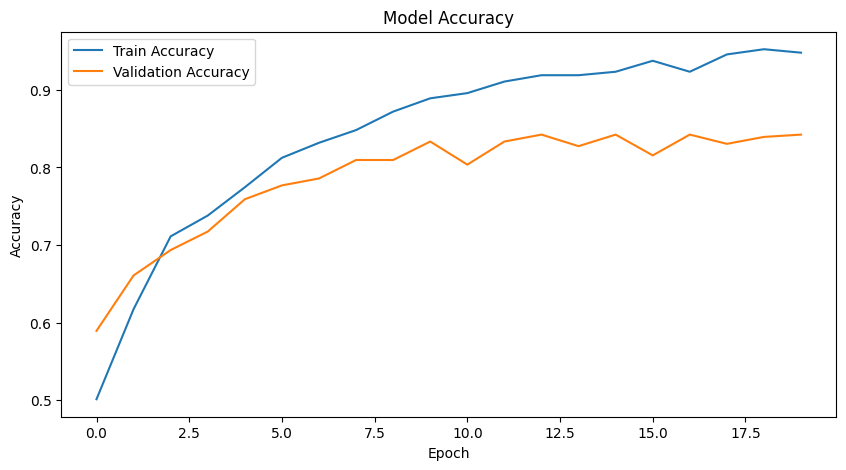

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

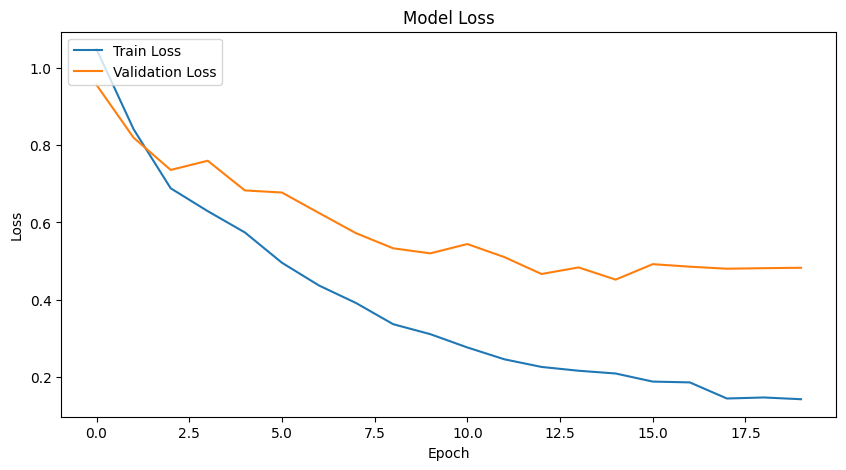

In [48]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [49]:
y_test_encoded.shape

(420,)

In [50]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)  # Use y_test_encoded
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)  # Use y_test_encoded
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8293 - loss: 0.5167
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9661 - loss: 0.1634
Train Accuracy: 94.28%
Test Accuracy: 82.14%


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


<Axes: >

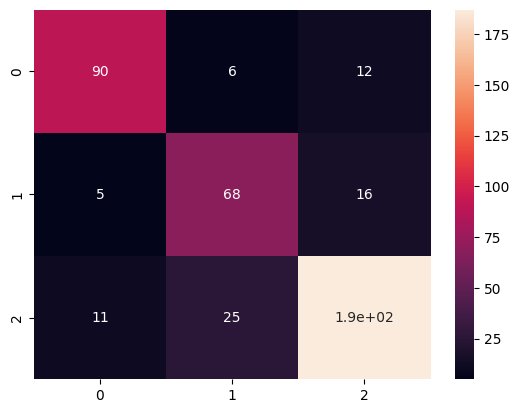

In [51]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(np.argmax(model.predict(X_test),axis=1),y_test_encoded),annot=True)

In [52]:
model = load_model('best_model.keras')

In [53]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)  # Use y_test_encoded
train_loss, train_accuracy = model.evaluate(X_train, y_train_encoded)  # Use y_test_encoded
print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8406 - loss: 0.4842
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9479 - loss: 0.2542
Train Accuracy: 92.61%
Test Accuracy: 83.10%


In [54]:
# train_accuracies =[]
# train_losses =[]
# test_accuracies =[]
# test_losses =[]

In [55]:
# train_accuracies.append(train_accuracy)
# train_losses.append(train_loss)
# test_accuracies.append(test_accuracy)
# test_losses.append(test_loss)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


<Axes: >

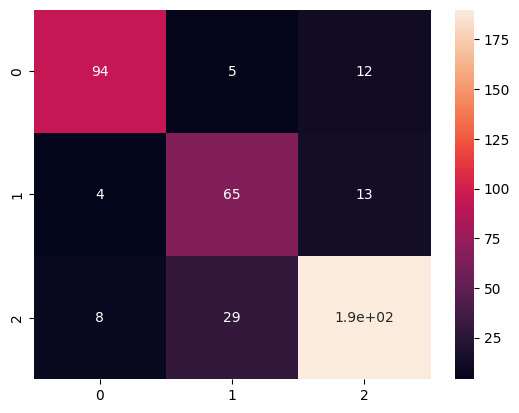

In [56]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

heatmap(confusion_matrix(np.argmax(model.predict(X_test),axis=1),y_test_encoded),annot=True)

In [698]:
# when i used the difference i got 58% in train and 57% in test
# when i used the preprocessed spectrogram i got 91.6% in train and 82.14% in test
# when i used the original data i got 63.97% in train and 62.62% in test
# when i used the preprocessed spectrogram with batch = 64 i got 95% in train and 82.86% in test
# when i used the preprocessed spectrogram with split valid = 0.2 i got 95.35% in train and 82.86% in test


In [699]:
# model.save_weights('models/processed_spetro_91.weights.h5')